# Mission - Analysez des images médicales avec des méthodes semi-supervisées

Vous êtes Data Scientist junior spécialisé en Computer Vision au sein de CurelyticsIA, une startup innovante dans le domaine de la e-santé. L’entreprise développe des solutions basées sur l’intelligence artificielle pour assister les professionnels de santé dans l’analyse d’images médicales, en particulier des IRM.
 
Dans le cadre d’un nouveau projet R&D, CurelyticsIA souhaite explorer la possibilité d’automatiser la détection de tumeurs du cerveau. Un ensemble conséquent de radios a été collecté : la majorité de ces images ne dispose d’aucun étiquetage, tandis qu’un sous-ensemble limité a été annoté par des radiologues experts.
 
Vous êtes chargé de concevoir une première exploration analytique du jeu de données. Plus précisément, votre mission est de :
- Explorer les images et extraire des caractéristiques visuelles via un modèle pré-entraîné ;
- Appliquer des méthodes de clustering pour identifier des structures ou regroupements dans les données ;
- Mettre en œuvre une méthode d’apprentissage semi-supervisé à partir des quelques étiquettes disponibles ;
- Synthétiser vos résultats, formuler des recommandations, et les présenter à votre équipe projet.

**Mail à prendre en compte :**

Comme discuté lors de notre dernière réunion, tu es assigné à la première phase du projet BrainScanAI. Tu trouveras en pièce jointe un fichier zip contenant :
- Le jeu de données de radiographies (en format PNG + métadonnées anonymisées),
- Une documentation technique sur le format des images ;
- Une liste restreinte de labels annotés par nos partenaires hospitaliers (normal/cancéreux). 

Pour info, notre budget actuel pour la labellisation par IA est de 300 euros pour ce dataset. 

Tes objectifs :
1) Extraire des caractéristiques visuelles pertinentes à l’aide d’un modèle pré-entraîné (type ResNet ou équivalent).
2) Réaliser un clustering exploratoire pour identifier des regroupements naturels.
3) Mettre en œuvre une méthode semi-supervisée en exploitant les labels partiels pour prédire les étiquettes manquantes.
4) Proposer des livrables au format Notebook contenant :
    - l’extraction des features
    - le preprocessing adapté au(x) modèle(s) utilisés
    - l’analyse non-supervisée (.ipynb)
    - l’entraînement de modèles de clustering
    - l’approche semi-supervisée (.ipynb)
 
Ces livrables doivent être accompagnés d’un support de présentation proposant des recommandations techniques pour un passage à l’échelle (budget de 5 000 euros pour 4 millions d’images à labelliser). Est-ce que ce passage te paraît faisable et si oui, sous quelles conditions ?

5) Rédiger une synthèse de ton approche et de tes résultats dans un support de présentation. Les contraintes :
    - Travailler en Python.
    - Tester plusieurs algorithmes.
    - Avoir des métriques pertinentes en fonction de l’erreur la plus importante (F1, Acc, Précision, ou autre ?).
    - Clairement définir ce que tu considères comme un objectif atteint (“definition of done”).


## Étape 1 - Importez les données et explorez le jeu de radiographies

Commencez par charger le dataset fourni par Clara. Effectuez une exploration visuelle des images, vérifiez leur résolution, canal de couleur et structure de fichiers.
 
**Prérequis**
- Avoir installé les bibliothèques nécessaires (Pillow, matplotlib, etc.)
 
**Résultat attendu**
- Vue d’ensemble du jeu de données, images d’exemple affichées et observations notées.
 
**Recommandations**
- Travailler sur un échantillon réduit pour les premières étapes.
- Vérifier la qualité et la cohérence des données.

**Outils**
- PyTorch, torchvision, NumPy, pandas, matplotlib

## Importation des librairies nécessaires

In [1]:
# Librairies de base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Librairies spécifiques
import os # permet de travailler avec le système de fichiers
from PIL import Image # ouvrir et manipuler des images

# Librairies PyTorch
import torchvision

#### Concernant les jeux de données, nous avons 2 dossiers : 
* "avec_labels" avec 2 sous-dossiers qui indiquent les 2 classes labellisées, "normal" et "cancer". 
* "sans_labels" qui regroupe les images sans label.

### On commence par regarder ce que nous avons dans chaque dossier :
* On va regarder si chaque image peut s'ouvrir
* La taille de chaque image
* Le format de chaque image
* Mettre en avant les images illisibles


In [2]:
# Fonction pour parcourir chaque dossier
def inspect_image_folder(folder_path):
    print(f"\n Analyse du dossier : {folder_path}\n")

    sizes = []
    modes = []
    formats = []
    corrupted = 0
    total = 0

    for fname in os.listdir(folder_path):
        if not fname.lower().endswith((".png", ".jpg", ".jpeg")):
            continue  # ignore les fichiers non-images

        total += 1
        fpath = os.path.join(folder_path, fname)

        try:
            img = Image.open(fpath)
            sizes.append(img.size)
            modes.append(img.mode)
            formats.append(img.format)
            img.close()
        except Exception as e:
            corrupted += 1
            print(f" Image corrompue ou illisible : {fname}")

    print(f"Nombre total d’images : {total}")
    print(f"Images corrompues : {corrupted}")

    if total - corrupted > 0:
        print(f"Tailles uniques : {set(sizes)}")
        print(f"Modes couleur (RGB, L, etc.) : {set(modes)}")
        print(f"Formats (PNG, JPG) : {set(formats)}")


#### Génération de la fonction pour chaque dossier

In [3]:
root = "../mri_dataset_brain_cancer_oc"

inspect_image_folder(os.path.join(root, "avec_labels/normal"))
inspect_image_folder(os.path.join(root, "avec_labels/cancer"))
inspect_image_folder(os.path.join(root, "sans_label"))



 Analyse du dossier : ../mri_dataset_brain_cancer_oc/avec_labels/normal

Nombre total d’images : 50
Images corrompues : 0
Tailles uniques : {(512, 512)}
Modes couleur (RGB, L, etc.) : {'RGB'}
Formats (PNG, JPG) : {'JPEG'}

 Analyse du dossier : ../mri_dataset_brain_cancer_oc/avec_labels/cancer

Nombre total d’images : 50
Images corrompues : 0
Tailles uniques : {(512, 512)}
Modes couleur (RGB, L, etc.) : {'RGB'}
Formats (PNG, JPG) : {'JPEG'}

 Analyse du dossier : ../mri_dataset_brain_cancer_oc/sans_label

Nombre total d’images : 1406
Images corrompues : 0
Tailles uniques : {(512, 512)}
Modes couleur (RGB, L, etc.) : {'RGB'}
Formats (PNG, JPG) : {'JPEG'}


#### On voit que nous avons des images propres et utilisables :
* Nous avons le même format pour chaque image
* Les 2 classes labellisées sont équilibrées
* Le mode de couelur RGB est utilisé pour l'ensemble des images
* Le nombre d'images correspond au montant affiché par Clara

#### Histogramme du nombre d'images par label 

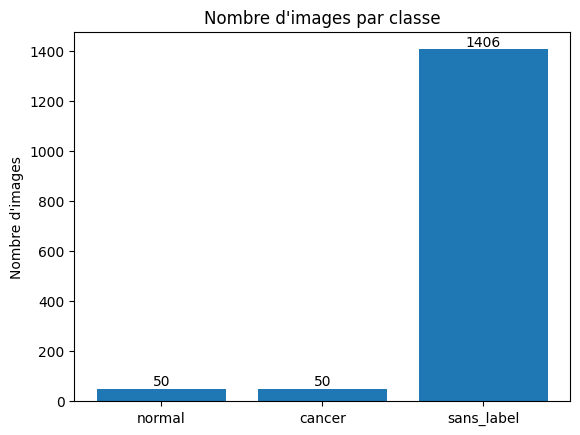

In [4]:
# Comptage directement avec les chemins complets
normal_count = len([f for f in os.listdir("../mri_dataset_brain_cancer_oc/avec_labels/normal") if f.endswith(('.png','.jpg'))])
cancer_count = len([f for f in os.listdir("../mri_dataset_brain_cancer_oc/avec_labels/cancer") if f.endswith(('.png','.jpg'))])
sans_label_count = len([f for f in os.listdir("../mri_dataset_brain_cancer_oc/sans_label") if f.endswith(('.png','.jpg'))])

# Histogramme
bars = plt.bar(["normal", "cancer", "sans_label"], 
        [normal_count, cancer_count, sans_label_count])
plt.bar_label(bars) # total par bar
plt.title("Nombre d'images par classe")
plt.ylabel("Nombre d'images")
plt.show()


* On confirme que le jeu labellisé est équilibré, 50 images pour "normal" et 50 pour "cancer"
* Avec 1406 images sans labels, nous avons un jeu qui est fait pour mettre en place une approche semi-supervisée


### Visualisation des images par dossier
#### Regardons les images médicales du dossier "normal"

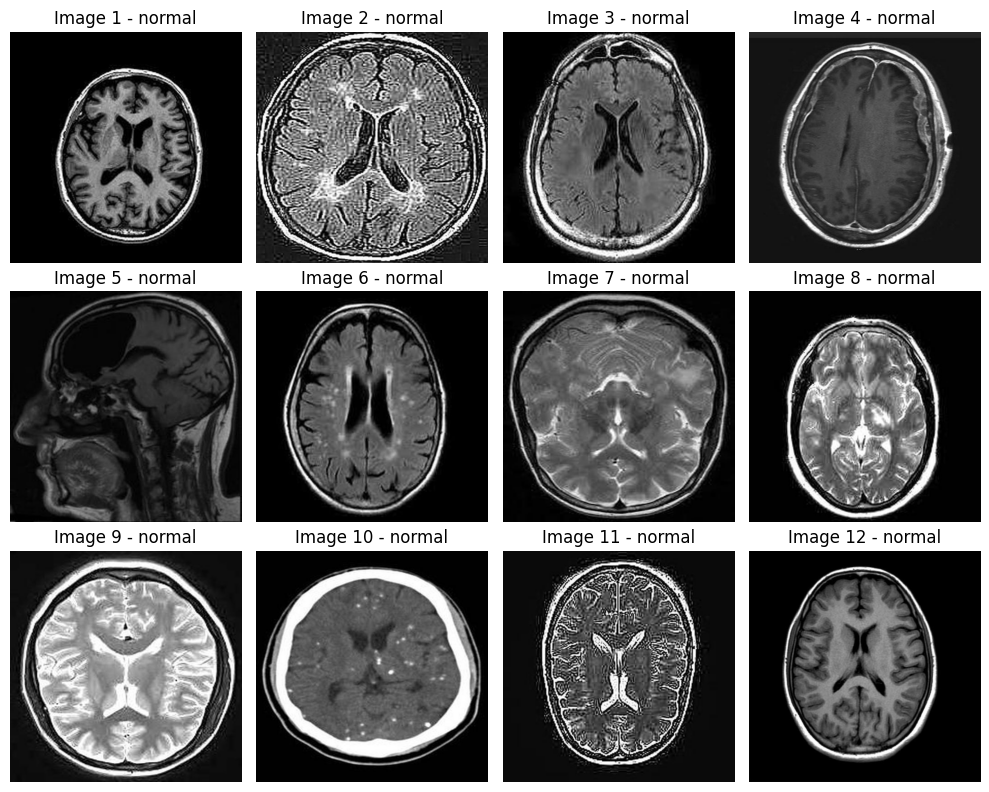

In [17]:
# Liste des chemins d'images
paths = [
    "../mri_dataset_brain_cancer_oc/avec_labels/normal/3c213abc-ab17-4037-a8e5-caa7bc1babe1.jpg",
    "../mri_dataset_brain_cancer_oc/avec_labels/normal/defdbef3-bea2-4f32-9d9a-62af1102ebfd.jpg",
    "../mri_dataset_brain_cancer_oc/avec_labels/normal/3ebe5f3a-90d3-4e79-af97-3d9584215044.jpg",
    "../mri_dataset_brain_cancer_oc/avec_labels/normal/3f4cb3e9-75fc-4b40-942c-327f2498b37d.jpg",
    "../mri_dataset_brain_cancer_oc/avec_labels/normal/4a08dc59-4f77-4ae0-80b4-749dbde82b82.jpg",
    "../mri_dataset_brain_cancer_oc/avec_labels/normal/4a71d847-c91b-481d-b112-3550c6655893.jpg",
    "../mri_dataset_brain_cancer_oc/avec_labels/normal/4a2102b8-0fb8-479a-ad2a-0b5e704489e5.jpg",
    "../mri_dataset_brain_cancer_oc/avec_labels/normal/6c861380-76ee-490d-bf28-a0232af08c43.jpg",
    "../mri_dataset_brain_cancer_oc/avec_labels/normal/6eb7dfc4-dd36-41cb-b5ea-f68c01aab86b.jpg",
    "../mri_dataset_brain_cancer_oc/avec_labels/normal/42ba7707-26c1-42bc-a00f-3d456741ef96.jpg",
    "../mri_dataset_brain_cancer_oc/avec_labels/normal/8e1cc70d-cccd-416c-99a5-df64bcadeb26.jpg",
    "../mri_dataset_brain_cancer_oc/avec_labels/normal/9e28ecf2-b8cd-4ea5-84b3-bf8f92d21f99.jpg"
]

# Chargement des images
images = [Image.open(p) for p in paths]

# Affichage
fig = plt.figure(figsize=(10, 8))

for i, img in enumerate(images):
    plt.subplot(3, 4, i+1) 
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Image {i+1} - normal")

plt.tight_layout()
plt.show()


Sur ce petit échantillon d'image classé comme "normal, on peut voir plusieurs choses intéressantes :
* On voit quelques images de bonne qualité comme l'image 1, la 4 ou la 12. Elles sont nettes.
* On voit que nous avons une image avec un angle différent (la 5) même si dans ce jeu nous avons principalement une vue de "haut".
* On peut noter des différences d'éclairage, certaines images avec beaucoup de lumière comme la 9 ou plus sombre comme la 5.
* Aussi il y a également des images avec une présence de bruit comme l'image 6 ou la 11. A bien avoir en tête car cela peut impacter nos résultats.
* On a également des images avec plus ou moins de profondeur, qui ciblent une partie du cerveau ou pas.


#### Regardons les images médicales du dossier "cancer"

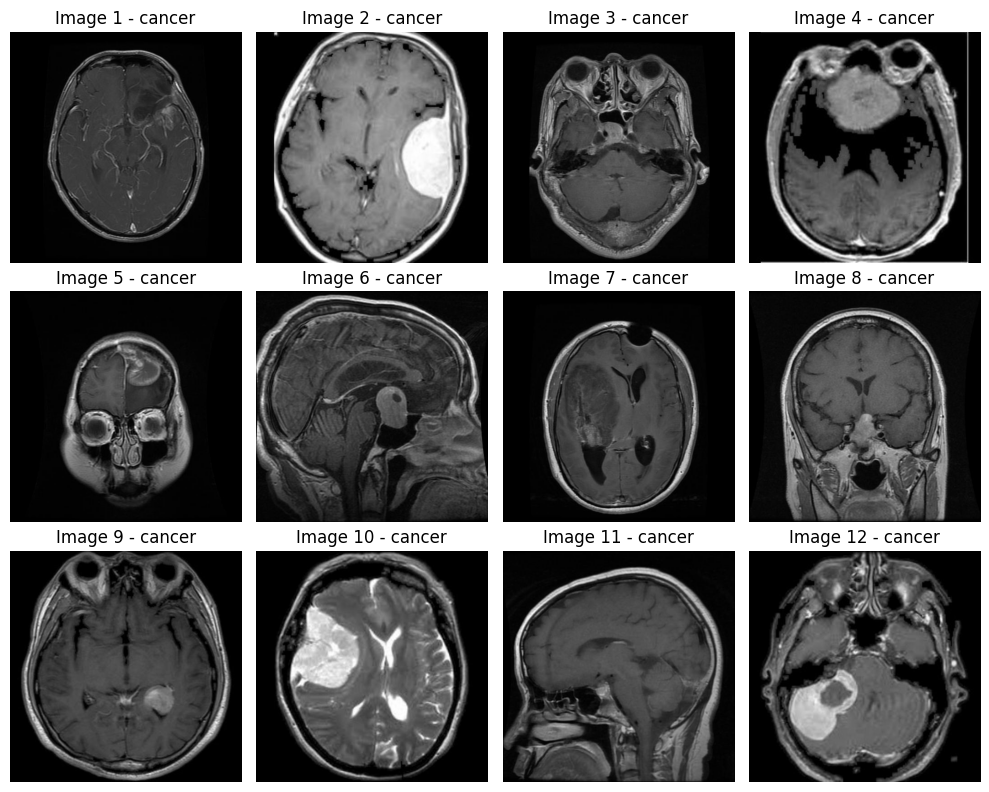

In [18]:
# Liste des chemins d'images
paths = [
    "../mri_dataset_brain_cancer_oc/avec_labels/cancer/0c6f3641-60d9-4a76-abe5-de89d55d5f2c.jpg",
    "../mri_dataset_brain_cancer_oc/avec_labels/cancer/c6c3d533-e366-42ff-9e69-fa2823910709.jpg",
    "../mri_dataset_brain_cancer_oc/avec_labels/cancer/1c043dbb-4623-4769-8e5e-0223bd745040.jpg",
    "../mri_dataset_brain_cancer_oc/avec_labels/cancer/11a7a426-4806-401e-98b2-b96e7094d1a6.jpg",
    "../mri_dataset_brain_cancer_oc/avec_labels/cancer/2d662cc1-509b-4657-a208-6d181aedd5e3.jpg",
    "../mri_dataset_brain_cancer_oc/avec_labels/cancer/2fa551e9-5b85-44f6-ab71-6035b4e3f8aa.jpg",
    "../mri_dataset_brain_cancer_oc/avec_labels/cancer/3c3d07cb-ec2a-43b0-b8a3-3a51573ad930.jpg",
    "../mri_dataset_brain_cancer_oc/avec_labels/cancer/4d14c944-eed4-4c4f-8fd9-cbbb53e8f35d.jpg",
    "../mri_dataset_brain_cancer_oc/avec_labels/cancer/5af7f2cb-a82b-4635-865e-5b57dbc7a087.jpg",
    "../mri_dataset_brain_cancer_oc/avec_labels/cancer/7e3f6acd-c9cc-440e-ba01-fedab0462fed.jpg",
    "../mri_dataset_brain_cancer_oc/avec_labels/cancer/9c3a8bbd-8bdb-4fdc-8573-7897d77224c9.jpg",
    "../mri_dataset_brain_cancer_oc/avec_labels/cancer/a8319ab8-471b-4d18-bb47-a377c4f9bd38.jpg"
]

# Chargement des images
images = [Image.open(p) for p in paths]

# Affichage
fig = plt.figure(figsize=(10, 8))

for i, img in enumerate(images):
    plt.subplot(3, 4, i+1) 
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Image {i+1} - cancer")

plt.tight_layout()
plt.show()


Sur ce petit échantillon d'image classé comme "cancer", on peut voir plusieurs choses intéressantes :
* On voit des images de bonne qualité comme l'image 1, la 4 ou la 7. Elles sont nettes.
* On voit que nous avons plusieurs images avec un angle différent (comme la 6 ou la 11), un peu plus de diversité que dans le jeu "normal".
* On peut noter des différences d'éclairage, on peut voir quelques zones ciblées mise en avant (tumeurs?), par exemple sur l'image 2, 10 et 12.
* Aussi il y a également des images avec une présence de bruit comme l'image 4.
* On a également des images avec plus ou moins de profondeur, qui ciblent une partie du cerveau ou pas.

#### Regardons les images médicales du dossier "sans label"

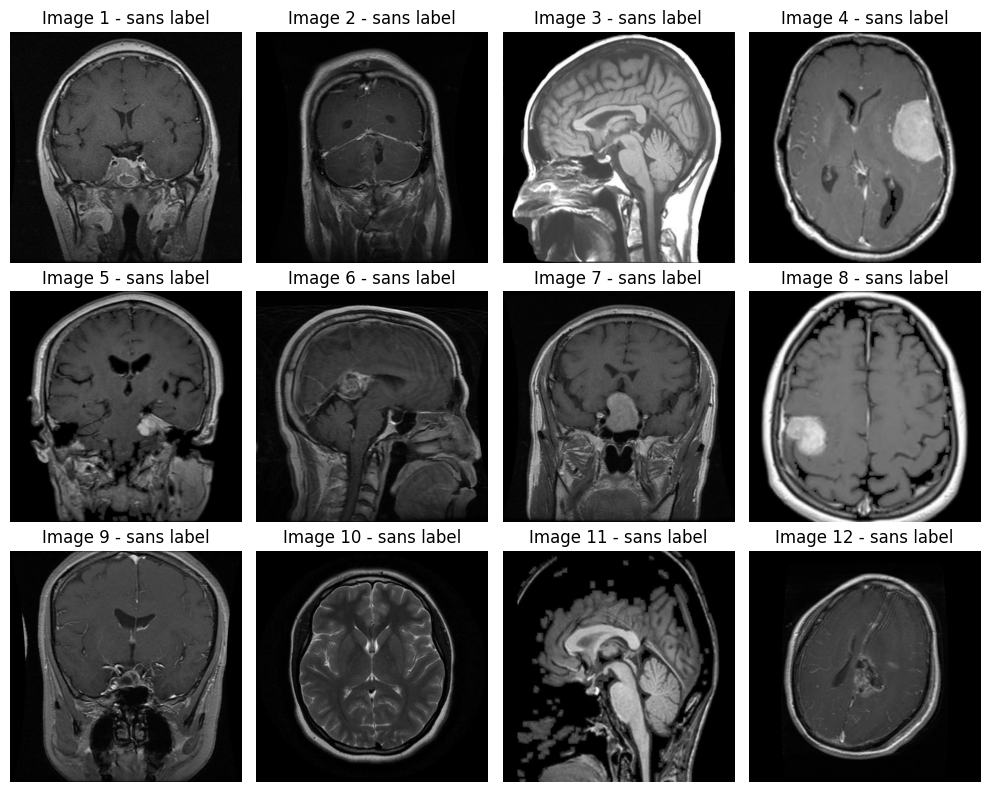

In [20]:
# Liste des chemins d'images
paths = [
    "../mri_dataset_brain_cancer_oc/sans_label/0a2bf85c-5b87-4069-8d47-059594d7fe95.jpg",
    "../mri_dataset_brain_cancer_oc/sans_label/b038504e-6513-4c61-83ea-6016dae07068.jpg",
    "../mri_dataset_brain_cancer_oc/sans_label/fa8ec37f-abf5-4028-8899-6416e8d8ffb1.jpg",
    "../mri_dataset_brain_cancer_oc/sans_label/fcf1c2ea-fe58-495e-b7b9-c30ee111b9cc.jpg",
    "../mri_dataset_brain_cancer_oc/sans_label/fecdc9e4-c3cf-490d-b5b4-b489a6d455bf.jpg",
    "../mri_dataset_brain_cancer_oc/sans_label/acd40feb-efc6-453d-befa-819b9502a4c2.jpg",
    "../mri_dataset_brain_cancer_oc/sans_label/ff3d5248-a7a7-47f6-8fe4-a44a45af64f5.jpg",
    "../mri_dataset_brain_cancer_oc/sans_label/fe4454fb-f164-40a8-b7ec-dca240430694.jpg",
    "../mri_dataset_brain_cancer_oc/sans_label/fb81733b-ea25-4003-80c7-7e162a731331.jpg",
    "../mri_dataset_brain_cancer_oc/sans_label/f6e10c2b-4aa7-49c4-bad2-dbd47dd30a78.jpg",
    "../mri_dataset_brain_cancer_oc/sans_label/fb0c6496-779b-4e6c-8d5f-684924504ab0.jpg",
    "../mri_dataset_brain_cancer_oc/sans_label/fc82dbe0-6824-4ac8-a4a0-612f5ea53a98.jpg"
]

# Chargement des images
images = [Image.open(p) for p in paths]

# Affichage
fig = plt.figure(figsize=(10, 8))

for i, img in enumerate(images):
    plt.subplot(3, 4, i+1) 
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Image {i+1} - sans label")

plt.tight_layout()
plt.show()


Sur ce petit échantillon d'image classé comme "sans label", on peut voir plusieurs choses intéressantes :
* On voit des images de bonne qualité comme l'image 1, la 3 ou la 10. Elles sont nettes.
* On voit que nous avons plusieurs images avec un angle différent comme la 3 ou la 6 ou la 12.
* On peut noter des différences d'éclairage, comme l'image 3 avec beaucoup de lumonisité. 
* Aussi il y a également des images avec une présence de bruit comme l'image 8.
* On a également des images avec plus ou moins de profondeur, qui ciblent une partie du cerveau ou pas.